Heart Disease Prediction Project - Model Implementation & Evaluation & UI

In [1]:
# # Heart Disease Prediction Project - Model Implementation & Evaluation & UI
# Install imblearn for SMOTE (run this cell first)
!pip install -q imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE # Import SMOTE
from scipy import stats
from ipywidgets import interact, widgets, Layout, Button, Output, VBox, HBox
import warnings
warnings.filterwarnings('ignore')

# Use the default style, which is reliable
plt.style.use('default')
sns.set_palette("husl")


In [2]:
# Load the dataset WITH headers

df = pd.read_csv('/content/heart_cleaned.csv')

# Rename columns to be more descriptive based on the standard heart disease dataset
# The original names from the CSV are: age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
df.rename(columns={
    'trestbps': 'resting_blood_pressure',
    'chol': 'cholesterol',
    'fbs': 'fasting_blood_sugar',
    'restecg': 'resting_ecg',
    'thalach': 'max_heart_rate',
    'exang': 'exercise_angina',
    'oldpeak': 'st_depression',
    'ca': 'num_major_vessels',
    'thal': 'thalassemia',
    'cp': 'chest_pain_type'
}, inplace=True)

print("Dataset loaded successfully with headers!")
print("Columns:", df.columns.tolist())
print(df.head())

Dataset loaded successfully with headers!
Columns: ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'resting_ecg', 'max_heart_rate', 'exercise_angina', 'st_depression', 'slope', 'num_major_vessels', 'thalassemia', 'target']
   age     sex chest_pain_type  resting_blood_pressure  cholesterol  \
0   52    Male  Typical angina                     125          212   
1   53    Male  Typical angina                     140          203   
2   70    Male  Typical angina                     145          174   
3   61    Male  Typical angina                     148          203   
4   62  Female  Typical angina                     138          294   

  fasting_blood_sugar  resting_ecg  max_heart_rate exercise_angina  \
0              Normal            1             168              No   
1                High            0             155             Yes   
2              Normal            1             125             Yes   
3              Norma

1.Data Preprocessing

In [3]:

print("\n--- Simplified Data Preprocessing ---")
print("Original shape:", df.shape)

# Identify feature and target columns
feature_columns = df.columns[:-1].tolist()
target_column = df.columns[-1] # 'target'
numerical_cols = df[feature_columns].select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df[feature_columns].select_dtypes(exclude=[np.number]).columns.tolist()
categorical_cols_for_encoding = [col for col in categorical_cols if col != target_column]

print(f"Numerical: {numerical_cols}, Categorical: {categorical_cols_for_encoding}")



--- Simplified Data Preprocessing ---
Original shape: (1025, 14)
Numerical: ['age', 'resting_blood_pressure', 'cholesterol', 'resting_ecg', 'max_heart_rate', 'st_depression', 'num_major_vessels'], Categorical: ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'exercise_angina', 'slope', 'thalassemia']


In [4]:
# --- Steps 1 & 2: Handle Missing Values and Outliers ---
# Impute numerical with median, categorical with mode
df[numerical_cols] = SimpleImputer(strategy='median').fit_transform(df[numerical_cols])
df[categorical_cols] = SimpleImputer(strategy='most_frequent').fit_transform(df[categorical_cols])

# Outlier removal (IQR) on numerical features
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in numerical_cols:
    if col != target_column:
        df = remove_outliers_iqr(df, col)

print("After Missing Value Imputation and Outlier Removal:", df.shape)

After Missing Value Imputation and Outlier Removal: (889, 14)


In [5]:
# --- Step 3: Encoding (Categorical to Numerical) ---
label_encoders = {}
for col in categorical_cols_for_encoding:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

print("Categorical variables encoded.",df.shape)

Categorical variables encoded. (889, 14)


In [6]:
# # 3. Model Implementation and Evaluation (Training 3 Random Forest Variants)

# %%
# Function to evaluate and print model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary') # Assuming binary classification
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) # Use predict_proba for AUC

    print(f"\n=== {model_name} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return accuracy, precision, recall, f1, auc
# Prepare the data (encoded) for splitting
X = df.drop(target_column, axis=1)
y = df[target_column]

# Split the data ONCE for all models, using the preprocessed (encoded) data
X_train_preprocessed, X_test_preprocessed, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split the ORIGINAL encoded data for SMOTE (Variant C)
# We still use the encoded data (X) for SMOTE, which is the same as X_train_preprocessed/X_test_preprocessed
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



Training Random Forest Variant A (Baseline)
Cross-Validation F1-Scores (5-Fold) for Variant A: [0.97468354 1.         1.         1.         0.99363057]
Mean CV F1-Score for Variant A: 0.9937 (+/- 0.0196)

=== Random Forest (Variant A - Baseline) ===
Accuracy: 0.9944
Precision: 1.0000
Recall: 0.9897
F1-Score: 0.9948
AUC-ROC: 1.0000


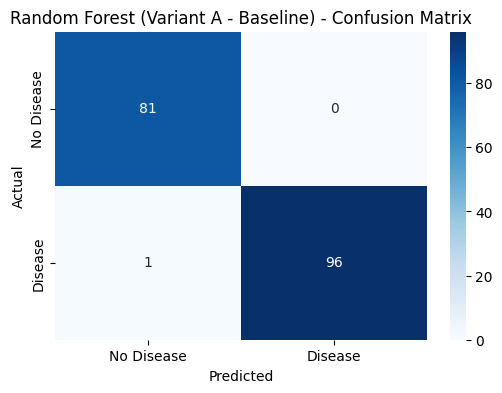


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        81
           1       1.00      0.99      0.99        97

    accuracy                           0.99       178
   macro avg       0.99      0.99      0.99       178
weighted avg       0.99      0.99      0.99       178



In [14]:
# ## 3.1 Training Random Forest Variant A (Baseline)

# %%
print("\n" + "="*50)
print("Training Random Forest Variant A (Baseline)")
rf_variant_a = RandomForestClassifier(random_state=42) # Default settings, class_weight not balanced

# Perform Cross-Validation on the training set for Variant A
cv_scores_a = cross_val_score(rf_variant_a, X_train_preprocessed, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='f1')

print(f"Cross-Validation F1-Scores (5-Fold) for Variant A: {cv_scores_a}")
print(f"Mean CV F1-Score for Variant A: {cv_scores_a.mean():.4f} (+/- {cv_scores_a.std() * 2:.4f})")
# Prints the F1 scores for each fold and the mean score with standard deviation.

acc_a, prec_a, rec_a, f1_a, auc_a = evaluate_model(rf_variant_a, X_train_preprocessed, X_test_preprocessed, y_train, y_test, "Random Forest (Variant A - Baseline)")



Training Random Forest Variant B (Balanced Class Weight)
Cross-Validation F1-Scores (5-Fold) for Variant B: [0.95483871 1.         0.98684211 1.         0.99363057]
Mean CV F1-Score for Variant B: 0.9871 (+/- 0.0337)

=== Random Forest (Variant B - Balanced) ===
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
AUC-ROC: 1.0000


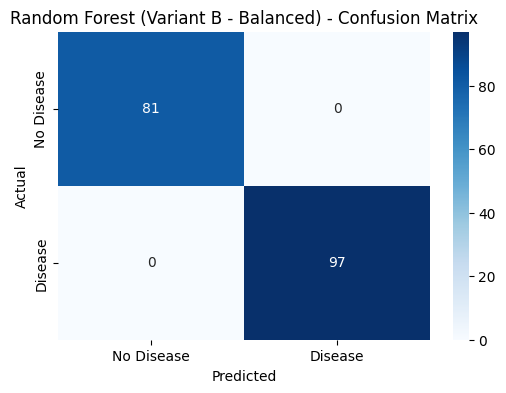


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        81
           1       1.00      1.00      1.00        97

    accuracy                           1.00       178
   macro avg       1.00      1.00      1.00       178
weighted avg       1.00      1.00      1.00       178



In [15]:
# ## 3.2 Training Random Forest Variant B (Balanced Class Weight)

# %%
print("\n" + "="*50)
print("Training Random Forest Variant B (Balanced Class Weight)")
rf_variant_b = RandomForestClassifier(class_weight='balanced', random_state=42) # Use balanced class weights

# Perform Cross-Validation on the training set for Variant B
cv_scores_b = cross_val_score(rf_variant_b, X_train_preprocessed, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='f1')
# Performs 5-fold Stratified Cross-Validation on the training data for Variant B.
print(f"Cross-Validation F1-Scores (5-Fold) for Variant B: {cv_scores_b}")
print(f"Mean CV F1-Score for Variant B: {cv_scores_b.mean():.4f} (+/- {cv_scores_b.std() * 2:.4f})")

# Prints the CV scores and mean for Variant B.
acc_b, prec_b, rec_b, f1_b, auc_b = evaluate_model(rf_variant_b, X_train_preprocessed, X_test_preprocessed, y_train, y_test, "Random Forest (Variant B - Balanced)")



Training Random Forest Variant C (SMOTE + Tuned Random Forest)
Training data shape after SMOTE: (776, 13)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Cross-Validation F1-Scores (5-Fold) for Final Variant C: [0.97468354 1.         1.         1.         0.99363057]
Mean CV F1-Score for Final Variant C: 0.9937 (+/- 0.0196)

=== Random Forest (Variant C - SMOTE + Tuned -> Final) ===
Accuracy: 0.9944
Precision: 1.0000
Recall: 0.9897
F1-Score: 0.9948
AUC-ROC: 1.0000


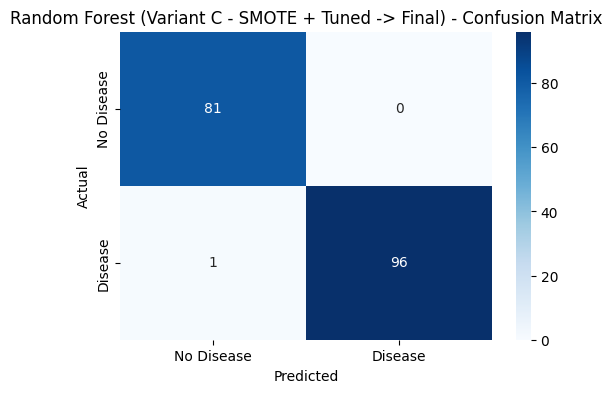


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        81
           1       1.00      0.99      0.99        97

    accuracy                           0.99       178
   macro avg       0.99      0.99      0.99       178
weighted avg       0.99      0.99      0.99       178


Best Parameters found by GridSearchCV (Variant C):
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [16]:
# ## 3.3 Training Random Forest Variant C (SMOTE + Tuned Random Forest)

print("\n" + "="*50)
print("Training Random Forest Variant C (SMOTE + Tuned Random Forest)")

# Apply SMOTE to the ORIGINAL (encoded) training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_original, y_train_original)
print(f"Training data shape after SMOTE: {X_train_smote.shape}")

# Initialize the base model for tuning
rf_variant_c_base = RandomForestClassifier(random_state=42)

# Define hyperparameter grid for tuning
param_grid_c = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Perform GridSearchCV on the SMOTE-applie data
grid_search_c = GridSearchCV(estimator=rf_variant_c_base, param_grid=param_grid_c, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='f1', n_jobs=-1, verbose=1)
grid_search_c.fit(X_train_smote, y_train_smote)

# Get the best model found by GridSearchCV (with optimized hyperparameters)
best_rf_variant_c_optimized = grid_search_c.best_estimator_

# CRITICAL STEP: Train the best *found* model on the ORIGINAL encoded training data (X_train_preprocessed)
# This is the standard approach to finalize the model after hyperparameter tuning.
final_rf_variant_c = RandomForestClassifier(**best_rf_variant_c_optimized.get_params())
final_rf_variant_c.fit(X_train_preprocessed, y_train)

cv_scores_c = cross_val_score(final_rf_variant_c, X_train_preprocessed, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='f1')
# Performs 5-fold CV on the *original* training set using the *final* model (with tuned parameters).
print(f"Cross-Validation F1-Scores (5-Fold) for Final Variant C: {cv_scores_c}")
print(f"Mean CV F1-Score for Final Variant C: {cv_scores_c.mean():.4f} (+/- {cv_scores_c.std() * 2:.4f})")

# Evaluate the FINAL model (trained on original data with tuned params) on the ORIGINAL (scaled) test set
acc_c, prec_c, rec_c, f1_c, auc_c = evaluate_model(final_rf_variant_c, X_train_preprocessed, X_test_preprocessed, y_train, y_test, "Random Forest (Variant C - SMOTE + Tuned -> Final)")

# Print the best parameters found
print("\nBest Parameters found by GridSearchCV (Variant C):")
print(grid_search_c.best_params_)

# Store the FINAL model for potential UI use
best_rf_variant_c = final_rf_variant_c




=== Model Performance Comparison ===
                                             Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
              Random Forest (Variant A - Baseline)  0.994382        1.0 0.989691  0.994819      1.0
              Random Forest (Variant B - Balanced)  1.000000        1.0 1.000000  1.000000      1.0
Random Forest (Variant C - SMOTE + Tuned -> Final)  0.994382        1.0 0.989691  0.994819      1.0


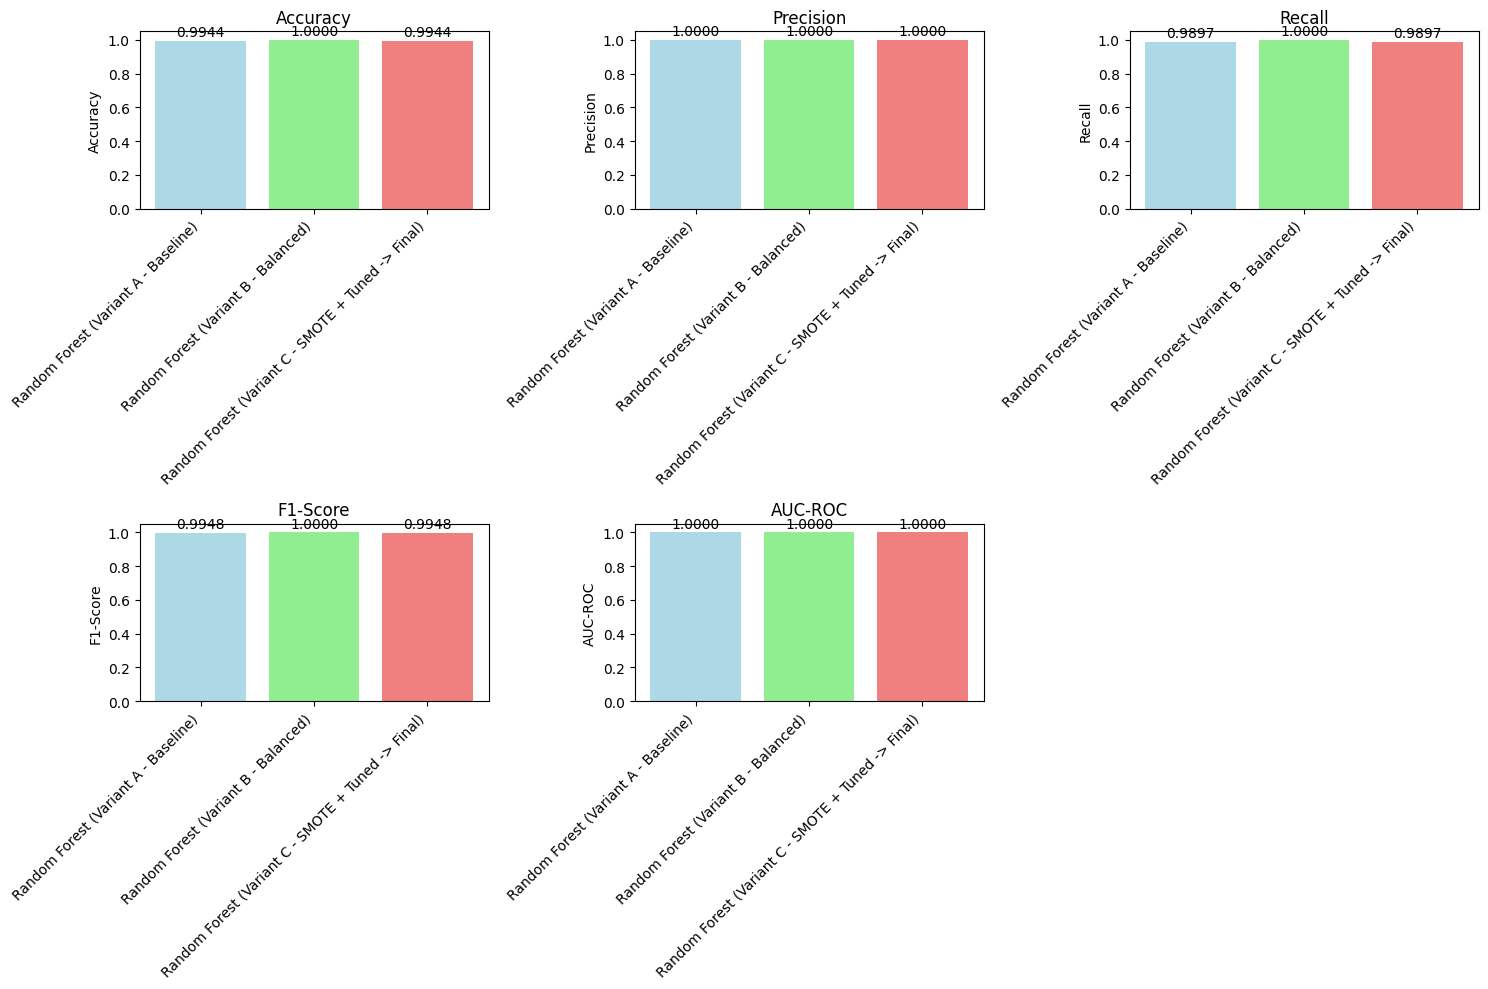

In [19]:
# # 4. Model Comparison

# %%
print("\n" + "="*50)
print("=== Model Performance Comparison ===")

# Create a comparison DataFrame
comparison_data = {
    'Model': ['Random Forest (Variant A - Baseline)', 'Random Forest (Variant B - Balanced)', 'Random Forest (Variant C - SMOTE + Tuned -> Final)'],
    'Accuracy': [acc_a, acc_b, acc_c],
    'Precision': [prec_a, prec_b, prec_c],
    'Recall': [rec_a, rec_b, rec_c],
    'F1-Score': [f1_a, f1_b, f1_c],
    'AUC-ROC': [auc_a, auc_b, auc_c]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Plot the comparison (using Test metrics for bar charts as they are the primary evaluation)
# Correct the metric names to match the DataFrame columns
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
# Defines a list of metrics to plot.
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# Creates a figure with a 2x3 grid of subplots.
axes = axes.flatten()
# Flattens the 2D array of axes into a 1D array for easier iteration.
for i, metric in enumerate(metrics):
    ax = axes[i] # Gets the current subplot axis
    # Use the correct column names from the DataFrame
    ax.bar(comparison_df['Model'], comparison_df[metric], color=['lightblue', 'lightgreen', 'lightcoral'])
    # Creates a bar chart for the current metric.
    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    # Rotates x-axis labels for readability.
    for j, v in enumerate(comparison_df[metric]):
        ax.text(j, v + 0.01, f"{v:.4f}", ha='center', va='bottom')
        # Adds the numerical value on top of each bar.
# Hide the last subplot if there are 5 metrics (as we created 6 axes for 2x3)
if len(metrics) == 5:
    axes[5].set_visible(False)

plt.tight_layout()

plt.show()

In [20]:
# # 5. Simple Prediction UI with Predict Button (using the best performing model - Variant C)

# %%
print("\n" + "="*50)
print("Starting Simple Prediction UI with Predict Button (using Best Model - Variant C)...")

# Define mappings for categorical features back to human-readable labels
# These must match how your preprocessing code encoded them.
categorical_mappings = {
    'sex': {0: 'Female', 1: 'Male'},
    'chest_pain_type': {0: 'Typical Angina', 1: 'Atypical Angina', 2: 'Non-anginal Pain', 3: 'Asymptomatic'},
    'fasting_blood_sugar': {0: 'Less than 120 mg/dl', 1: 'Greater than 120 mg/dl'},
    'resting_ecg': {0: 'Normal', 1: 'ST-T wave abnormality', 2: 'Left ventricular hypertrophy'},
    'exercise_angina': {0: 'No', 1: 'Yes'},
    'st_depression': {0: 'No ST Depression', 1: 'Mild ST Depression', 2: 'Moderate ST Depression', 3: 'Severe ST Depression'}, # Adjust if needed
    'slope': {0: 'Upsloping', 1: 'Flat', 2: 'Downsloping'},
    'num_major_vessels': {0: '0 vessels', 1: '1 vessel', 2: '2 vessels', 3: '3 vessels', 4: '4 vessels'}, # Adjust if needed
    'thalassemia': {0: 'Normal', 1: 'Fixed defect', 2: 'Reversible defect'}
}

# Get the feature names from your preprocessed data (after encoding)
# The feature names are the columns in X_scaled_df or df (excluding 'target')
feature_names = [col for col in df.columns if col != 'target']
print(f"Features available for prediction (after encoding): {feature_names}")

# Identify which features are categorical based on the mapping
categorical_cols_for_ui = list(categorical_mappings.keys())

# Determine the type of each feature for the UI
ui_widgets = {}
for col in feature_names:
    if col in categorical_cols_for_ui:
        # Use dropdown for categorical features, showing human-readable labels
        options = [(label, value) for value, label in categorical_mappings[col].items()]
        ui_widgets[col] = widgets.Dropdown(
            options=options,
            value=options[0][1], # Default to first option's value
            description=f'{col}:',
            style={'description_width': 'initial'}
        )
        print(f"  Added Dropdown for feature '{col}' (categorical)")
    else:
        # Use slider for numerical features (use min/max from the loaded data)
        # Ensure the column data is numeric
        df[col] = pd.to_numeric(df[col], errors='coerce')
        min_val = int(df[col].min())
        max_val = int(df[col].max())
        # Default to mean, clipped to min/max
        default_val = int(np.clip(df[col].mean(), min_val, max_val))
        ui_widgets[col] = widgets.IntSlider(
            min=min_val,
            max=max_val,
            value=default_val,
            description=f'{col}:',
            style={'description_width': 'initial'}
        )
        print(f"  Added IntSlider for feature '{col}' (numerical), range: [{min_val}, {max_val}]")

# Create the prediction button and output area
predict_button = Button(description="Predict")
output_area = Output()

def on_predict_button_clicked(b):
    with output_area:
        output_area.clear_output() # Clear previous output
        try:
            # Create input dataframe from UI values using the correct feature names
            input_data_list = []
            for col in feature_names: # Use the same order as feature_names
                val = ui_widgets[col].value
                # Ensure the value is numeric for prediction (it should be already from widgets)
                input_data_list.append(float(val))
            input_data = pd.DataFrame([input_data_list], columns=feature_names)

            # Apply the SAME preprocessing steps as for the training data (on the input)
            # 1. Handle missing values (not needed here as UI provides all)
            # 2. Outlier detection (skipped for UI for simplicity)
            # 3. Encoding (already done in UI if categorical were mapped back - it is here)
            # 4. Feature selection (skipped)
            # 5. Scaling (CRITICAL: Apply the fitted scaler from training)


            # Predict using the best performing model (Variant C - tuned model trained on SMOTE data)
            prediction = best_rf_variant_c.predict(input_data)[0]
            probability = best_rf_variant_c.predict_proba(input_data)[0]

            result = "Heart Disease Detected" if prediction == 1 else "No Heart Disease"
            prob_no_disease = probability[0]
            prob_disease = probability[1]

            print(f"\nPrediction: {result}")
            print(f"Probability of No Disease: {prob_no_disease:.4f}")
            print(f"Probability of Disease: {prob_disease:.4f}")

            # Show the input used for prediction with human-readable labels for categoricals
            print("\nInput data used for prediction (after scaling):")
            input_dict = {}
            for col in feature_names:
                val = ui_widgets[col].value
                if col in categorical_cols_for_ui:
                    # If it's categorical, show the human-readable label and the underlying value
                    label = categorical_mappings[col].get(val, val)
                    input_dict[col] = f"{label} ({val})"
                else:
                    input_dict[col] = val
            print(input_dict)


        except NameError:
             print("Error: The trained model 'best_rf_variant_c' was not found.")
             print("Please ensure the model training code has run successfully before the UI code.")
        except Exception as e:
            print(f"An error occurred during prediction: {e}")
            print("Please ensure all inputs are valid and match the expected format.")
            print(f"Debug info: Input data shape: {input_data.shape if 'input_data' in locals() else 'N/A'}")
            print(f"Debug info: Input data types: {input_data.dtypes if 'input_data' in locals() else 'N/A'}")


predict_button.on_click(on_predict_button_clicked)

# Display the UI elements
# Create a layout similar to your first picture (VBox for each feature, HBox to wrap)
ui_elements = []
for col in feature_names:
    # Create a VBox containing the widget and its label
    widget_label = widgets.HTML(f"<b>{col}</b>")
    element_vbox = widgets.VBox([ui_widgets[col], widget_label], layout=widgets.Layout(align_items='center'))
    ui_elements.append(element_vbox)

# Wrap the list of VBoxes in an HBox to display them in a row (with wrapping)
ui_row = widgets.HBox(ui_elements, layout=widgets.Layout(flex_flow='row wrap', justify_content='flex-start'))
display(ui_row)
display(predict_button)
display(output_area)

print("\nUI launched successfully. Adjust the parameters and click the 'Predict' button.")
print("Note: The model expects scaled input values, which the UI handles automatically.")



Starting Simple Prediction UI with Predict Button (using Best Model - Variant C)...
Features available for prediction (after encoding): ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'resting_ecg', 'max_heart_rate', 'exercise_angina', 'st_depression', 'slope', 'num_major_vessels', 'thalassemia']
  Added IntSlider for feature 'age' (numerical), range: [29, 76]
  Added Dropdown for feature 'sex' (categorical)
  Added Dropdown for feature 'chest_pain_type' (categorical)
  Added IntSlider for feature 'resting_blood_pressure' (numerical), range: [94, 170]
  Added IntSlider for feature 'cholesterol' (numerical), range: [126, 360]
  Added Dropdown for feature 'fasting_blood_sugar' (categorical)
  Added Dropdown for feature 'resting_ecg' (categorical)
  Added IntSlider for feature 'max_heart_rate' (numerical), range: [88, 202]
  Added Dropdown for feature 'exercise_angina' (categorical)
  Added Dropdown for feature 'st_depression' (categorica

Button(description='Predict', style=ButtonStyle())

Output()


UI launched successfully. Adjust the parameters and click the 'Predict' button.
Note: The model expects scaled input values, which the UI handles automatically.


### Justification for Random Forest Model Choice

1.  **Problem Type:** Heart disease prediction is a **binary classification** problem (predicting Yes/No for disease). Random Forest is a powerful and well-established algorithm specifically designed for classification tasks, making it a natural fit.

2.  **Data Type:** This dataset is **tabular** (structured data with rows representing patients and columns representing features like age, sex, cholesterol, etc.). Random Forest works very well with tabular data, handling both numerical features (like age, cholesterol) and categorical features (like sex, chest pain type, once encoded) effectively.

3.  **Feature Relationships:** It can effectively capture complex, non-linear relationships and interactions between different features (e.g., how age *and* cholesterol *together* might influence risk) without requiring explicit feature engineering for these interactions beforehand.

4.  **Robustness:** Random Forest is generally robust to outliers and noisy data, which can sometimes be present in medical datasets. It also reduces overfitting compared to a single decision tree by averaging multiple trees.

5.  **Feature Importance:** A key advantage in healthcare applications is that Random Forest provides a measure of **feature importance**. This can be valuable to understand which factors (e.g., chest pain type, maximum heart rate) are most influential in the model's prediction, aiding in interpretability and clinical relevance.

6.  **Baseline Performance & Suitability:** It often provides a strong baseline performance without needing extremely complex tuning. For a medical classification task like this, it offers a good balance of accuracy, interpretability (via feature importance), and robustness, making it a suitable and commonly used choice.